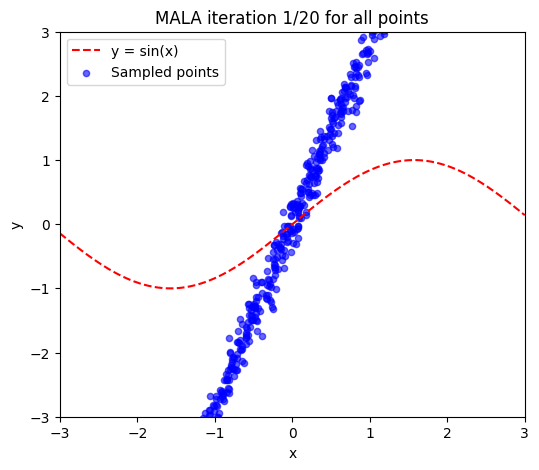

/tmp/ipykernel_1055891/47800280.py:140: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_path)


✅ GIF saved to /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/mala_sampling.gif
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_000.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_001.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_002.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_003.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_004.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_005.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_006.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_007.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_008.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_009.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_010.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/fr

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio

np.random.seed(42)

# ================ 定义目标分布和梯度 =================
def log_tar_y_given_xz(y, x, z, alpha=1.0, beta=5.0):
    """
    log P_tar(y|x,z) = log_pre(y) + beta * R(x,y)
    其中 log_pre(y) = -1/2 * y^2, R(x,y) = -alpha * (y - sin x)^2
    """
    log_pre_y = -0.5 * y**2
    reward = -alpha * (y - np.sin(x))**2
    return log_pre_y + beta * reward

def grad_log_tar_y_given_xz(y, x, z, alpha=1.0, beta=5.0):
    """
    计算梯度:
      grad log_pre_y(y) = -y
      grad R(x,y) = -2 alpha (y - sin x)
    => grad = -y + beta * [ -2 alpha (y - sin x) ]
    """
    grad_pre = -y
    grad_reward = -2 * alpha * (y - np.sin(x))
    return grad_pre + beta * grad_reward

# ================ MALA 相关函数 =================
def mala_step_y(y, x, z, step_size, alpha, beta):
    """
    单步 MALA:
    y' = y + 0.5*step_size*grad + sqrt(step_size)*N(0,1)
    """
    g = grad_log_tar_y_given_xz(y, x, z, alpha, beta)
    mean = y + 0.5 * step_size * g
    y_prop = mean + np.sqrt(step_size) * np.random.randn()
    return y_prop, mean, g

def mala_log_q(y_from, mean_from, y_to, step_size):
    """
    Proposal 分布 q(y_to | y_from) ~ N(mean_from, step_size)
    log q = -0.5*[log(2*pi*step_size) + (y_to - mean_from)^2 / step_size]
    """
    diff = y_to - mean_from
    return -0.5 * (np.log(2 * np.pi * step_size) + diff**2 / step_size)

# ================ MALA 更新所有点 =================
def mala_update_all_points(xs, zs, ys, n_steps, step_size=0.1, alpha=1.0, beta=5.0, ax=None, scatter=None, fig=None, save_dir=None):
    """
    更新所有点的 y (固定 x, z), 并在每一步 MALA 后动态更新所有点
    """
    num_samples = len(xs)

    for t in range(n_steps):
        for i in range(num_samples):
            x, z, y = xs[i], zs[i], ys[i]

            # 计算当前 log_prob
            current_log_tar = log_tar_y_given_xz(y, x, z, alpha, beta)

            # 执行 MALA 提议
            y_prop, mean_fwd, g_fwd = mala_step_y(y, x, z, step_size, alpha, beta)

            # 计算 log_prob of proposal
            log_tar_prop = log_tar_y_given_xz(y_prop, x, z, alpha, beta)

            # 计算 forward 和 backward 的 q
            log_q_fwd = mala_log_q(y, mean_fwd, y_prop, step_size)
            g_bwd = grad_log_tar_y_given_xz(y_prop, x, z, alpha, beta)
            mean_bwd = y_prop + 0.5 * step_size * g_bwd
            log_q_bwd = mala_log_q(y_prop, mean_bwd, y, step_size)

            # 计算 Metropolis 接受率
            log_accept = (log_tar_prop - current_log_tar) + (log_q_bwd - log_q_fwd)
            if np.log(np.random.rand()) < log_accept:
                ys[i] = y_prop  # 接受提议
            else:
                ys[i] = y  # 拒绝, 保持 y 不变

        # ✅ 每一步 MALA 结束后, 更新所有点的散点图
        if ax is not None and scatter is not None and fig is not None:
            scatter.set_offsets(np.column_stack((xs, ys)))  # 更新散点
            ax.set_title(f"MALA iteration {t+1}/{n_steps} for all points")
            plt.pause(0.1)  # 短暂停顿以显示
            fig.canvas.flush_events()  # 强制刷新图像

            # ✅ 保存当前帧
            if save_dir:
                frame_path = os.path.join(save_dir, f"frame_{t:03d}.png")
                fig.savefig(frame_path)

    return ys


# ================ 主函数：更新采样点并生成 GIF =================
def main():
    num_samples = 500  # 生成 100 个点
    n_steps_mala = 20  # 每个 (x, y, z) 进行 10 次 MALA 更新
    step_size = 0.05
    alpha = 1.0
    beta = 10.0

    # 1) 生成 x, z 来自 N(0,1)
    xs = np.random.randn(num_samples)
    zs = np.random.randn(num_samples)

    # 2) 初始化 y 来自 N(0,1)
    ys = np.random.randn(num_samples)*0.1+5*xs

    # ========== 目标路径 ==========
    save_dir = "/cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling"
    os.makedirs(save_dir, exist_ok=True)

    # ============= 动态可视化 =============
    plt.ion()  # 打开交互模式
    fig, ax = plt.subplots(figsize=(6, 5))
    xx = np.linspace(-3, 3, 200)

    # 画目标参考线 y = sin(x)
    ax.plot(xx, np.sin(xx), 'r--', label="y = sin(x)")
    scatter = ax.scatter(xs, ys, s=20, c='blue', alpha=0.6, label="Sampled points")

    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()

    # 3) 对所有点进行 10 步 MALA 更新, 并在每一步 MALA 后更新图像
    ys = mala_update_all_points(
        xs, zs, ys, n_steps_mala, step_size, alpha, beta, ax=ax, scatter=scatter, fig=fig, save_dir=save_dir
    )

    # 4) 生成 GIF 动画
    gif_path = os.path.join(save_dir, "mala_sampling.gif")
    frame_paths = [os.path.join(save_dir, f"frame_{t:03d}.png") for t in range(n_steps_mala)]
    with imageio.get_writer(gif_path, mode="I", duration=0.2) as writer:
        for frame_path in frame_paths:
            image = imageio.imread(frame_path)
            writer.append_data(image)

    print(f"✅ GIF saved to {gif_path}")

    # ✅ 5) 删除中间 PNG 帧
    for frame_path in frame_paths:
        if os.path.exists(frame_path):
            os.remove(frame_path)
            print(f"Deleted {frame_path}")

    # 6) 关闭交互式, 显示最终图
    plt.ioff()
    plt.show()


if __name__ == "__main__":
    main()

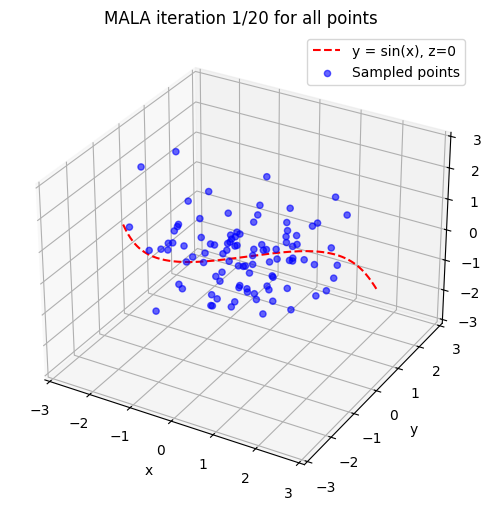

/tmp/ipykernel_1055891/2930181117.py:147: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_path)


✅ 3D GIF with y = sin(x) saved to /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/mala_sampling_3d.gif
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_000.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_001.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_002.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_003.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_004.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_005.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_006.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_007.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_008.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_009.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling/frame_010.png
Deleted /cpfs04/user/hanyujin/rule-gen/rule

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)

# ================ 定义目标分布和梯度 =================
def log_tar_y_given_xz(y, x, z, alpha=1.0, beta=5.0):
    """
    log P_tar(y|x,z) = log_pre(y) + beta * R(x,y)
    其中 log_pre(y) = -1/2 * y^2, R(x,y) = -alpha * (y - sin x)^2
    """
    log_pre_y = -0.5 * y**2
    reward = -alpha * (y - np.sin(x))**2
    return log_pre_y + beta * reward

def grad_log_tar_y_given_xz(y, x, z, alpha=1.0, beta=5.0):
    """
    计算梯度:
      grad log_pre_y(y) = -y
      grad R(x,y) = -2 alpha (y - sin x)
    => grad = -y + beta * [ -2 alpha (y - sin x) ]
    """
    grad_pre = -y
    grad_reward = -2 * alpha * (y - np.sin(x))
    return grad_pre + beta * grad_reward

# ================ MALA 相关函数 =================
def mala_step_y(y, x, z, step_size, alpha, beta):
    """
    单步 MALA:
    y' = y + 0.5*step_size*grad + sqrt(step_size)*N(0,1)
    """
    g = grad_log_tar_y_given_xz(y, x, z, alpha, beta)
    mean = y + 0.5 * step_size * g
    y_prop = mean + np.sqrt(step_size) * np.random.randn()
    return y_prop, mean, g

def mala_log_q(y_from, mean_from, y_to, step_size):
    """
    Proposal 分布 q(y_to | y_from) ~ N(mean_from, step_size)
    log q = -0.5*[log(2*pi*step_size) + (y_to - mean_from)^2 / step_size]
    """
    diff = y_to - mean_from
    return -0.5 * (np.log(2 * np.pi * step_size) + diff**2 / step_size)

# ================ MALA 更新所有点 =================
def mala_update_all_points(xs, zs, ys, n_steps, step_size=0.1, alpha=1.0, beta=5.0, ax=None, scatter=None, fig=None, save_dir=None):
    """
    更新所有点的 y (固定 x, z), 并在每一步 MALA 后动态更新所有点
    """
    num_samples = len(xs)

    for t in range(n_steps):
        for i in range(num_samples):
            x, z, y = xs[i], zs[i], ys[i]

            # 计算当前 log_prob
            current_log_tar = log_tar_y_given_xz(y, x, z, alpha, beta)

            # 执行 MALA 提议
            y_prop, mean_fwd, g_fwd = mala_step_y(y, x, z, step_size, alpha, beta)

            # 计算 log_prob of proposal
            log_tar_prop = log_tar_y_given_xz(y_prop, x, z, alpha, beta)

            # 计算 forward 和 backward 的 q
            log_q_fwd = mala_log_q(y, mean_fwd, y_prop, step_size)
            g_bwd = grad_log_tar_y_given_xz(y_prop, x, z, alpha, beta)
            mean_bwd = y_prop + 0.5 * step_size * g_bwd
            log_q_bwd = mala_log_q(y_prop, mean_bwd, y, step_size)

            # 计算 Metropolis 接受率
            log_accept = (log_tar_prop - current_log_tar) + (log_q_bwd - log_q_fwd)
            if np.log(np.random.rand()) < log_accept:
                ys[i] = y_prop  # 接受提议
            else:
                ys[i] = y  # 拒绝, 保持 y 不变

        # ✅ 每一步 MALA 结束后, 更新所有点的散点图
        if ax is not None and scatter is not None and fig is not None:
            scatter._offsets3d = (xs, ys, zs)  # 更新 3D 散点数据
            ax.set_title(f"MALA iteration {t+1}/{n_steps} for all points")
            plt.pause(0.1)  # 短暂停顿以显示
            fig.canvas.flush_events()  # 强制刷新图像

            # ✅ 保存当前帧
            if save_dir:
                frame_path = os.path.join(save_dir, f"frame_{t:03d}.png")
                fig.savefig(frame_path)

    return ys


# ================ 主函数：更新采样点并生成 GIF =================
def main():
    num_samples = 100  # 生成 100 个点
    n_steps_mala = 20  # 每个 (x, y, z) 进行 10 次 MALA 更新
    step_size = 0.05
    alpha = 1.0
    beta = 10.0

    # 1) 生成 x, z 来自 N(0,1)
    xs = np.random.randn(num_samples)
    zs = np.random.randn(num_samples)

    # 2) 初始化 y 来自 N(0,1)
    ys = np.random.randn(num_samples)

    # ========== 目标路径 ==========
    save_dir = "/cpfs04/user/hanyujin/rule-gen/rule_tokenizer/sampling"
    os.makedirs(save_dir, exist_ok=True)

    # ============= 动态 3D 可视化 =============
    plt.ion()  # 打开交互模式
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    # ✅ 3D 曲线 y = sin(x), z=0 平面
    xx = np.linspace(-3, 3, 200)
    yy = np.sin(xx)
    zz = np.zeros_like(xx)
    ax.plot3D(xx, yy, zz, 'r--', label="y = sin(x), z=0")

    # ✅ 初始绘制 (x, y, z) 轨迹
    scatter = ax.scatter(xs, ys, zs, s=20, c='blue', alpha=0.6, label="Sampled points")
    ax.set_xlim3d([-3, 3])
    ax.set_ylim3d([-3, 3])
    ax.set_zlim3d([-3, 3])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.legend()

    # 3) 对所有点进行 10 步 MALA 更新, 并在每一步 MALA 后更新 3D 图像
    ys = mala_update_all_points(
        xs, zs, ys, n_steps_mala, step_size, alpha, beta, ax=ax, scatter=scatter, fig=fig, save_dir=save_dir
    )

    # 4) 生成 GIF 动画
    gif_path = os.path.join(save_dir, "mala_sampling_3d.gif")
    frame_paths = [os.path.join(save_dir, f"frame_{t:03d}.png") for t in range(n_steps_mala)]
    with imageio.get_writer(gif_path, mode="I", duration=0.2) as writer:
        for frame_path in frame_paths:
            image = imageio.imread(frame_path)
            writer.append_data(image)

    print(f"✅ 3D GIF with y = sin(x) saved to {gif_path}")

    # ✅ 5) 删除中间 PNG 帧
    for frame_path in frame_paths:
        if os.path.exists(frame_path):
            os.remove(frame_path)
            print(f"Deleted {frame_path}")

    # 6) 关闭交互式, 显示最终图
    plt.ioff()
    plt.show()


if __name__ == "__main__":
    main()


# Grad

In [1]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor,Qwen2VLForConditionalGeneration
# from transformers import AutoProcessor,Qwen2VLForConditionalGeneration
import numpy as np
from qwen_vl_utils import process_vision_info

local_path = "/cpfs04/shared/CausaLLMs/HuggingfaceModels/Qwen2.5-VL-7B-Instruct"

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    local_path, torch_dtype="auto", device_map="auto"
)

# local_path = "/cpfs04/shared/CausaLLMs/HuggingfaceModels/QVQ-72B-Preview"

# model = Qwen2VLForConditionalGeneration.from_pretrained(
#     local_path, torch_dtype="auto", device_map="auto"
# )

processor = AutoProcessor.from_pretrained(local_path)

/root/miniconda3/envs/yjenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-03-31 13:20:46.273221: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-31 13:20:46.286974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743398446.303096 3025288 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743398446.307712 3025288 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743398446.320055 3025288 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Grads shape: torch.Size([100, 1176])
Reshaped grads shape: torch.Size([10, 10, 1176])
Grad norm shape: (10, 10)
Image size: torch.Size([100, 1176])
PATCH_SIZE: 10


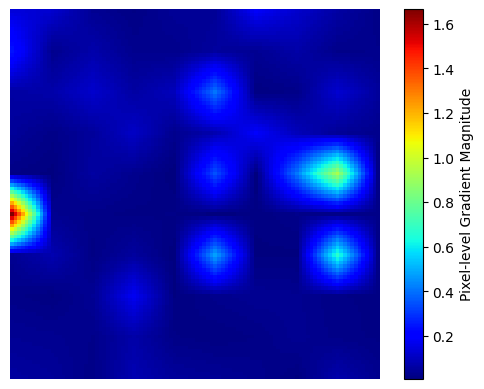

The image_path is /cpfs04/user/hanyujin/rule-gen/datasets/mirrors/left/00003.png
Model Answer: ["Alright, I've got this task to rate images based on how well an object and its reflection match in shape and outline. The object is in front of a mirror, so I need to consider the reflection as if it's the back of the same object. Colors and textures can be different, but the shapes should be consistent, except for minor distortions due to perspective.\n\nFirst, I need to understand what constitutes a perfect match. A score of 10 means the object and its reflection are identical in shape and outline, considering the mirror flip. So, if I have an object and its exact mirror image, that should be a 10.\n\nNow, the scale goes down from there. A score of 9 would mean there are minor distortions due to perspective, but overall, the shape is recognizable. Maybe the reflection appears slightly distorted because of the angle or the surface it's reflecting on, but it's still clearly the same object.

AttributeError: 'NoneType' object has no attribute 'group'

In [7]:
# Standrad
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom
import re
from transformers import AutoTokenizer
# image_path = "/cpfs04/user/hanyujin/rule-gen/datasets/mirrors/left/00001.png"
image_path = "/cpfs04/user/hanyujin/rule-gen/datasets/mirrors/left/00003.png"
# image_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0/000003.png"
# image_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0/000009.png"
# image_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-JEPA-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0/000000.png"
# image_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-JEPA-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0/000005.png"
image_size = 128
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image_path,"resized_height":image_size,"resized_width":image_size},
            {"type": "text", "text": (
                "You are an expert in visual anomaly detection, focusing primarily on the shape and outline of objects. You will see images of an object in front of a mirror and its reflection. Specifically, please pay close attention to the outline and shape differences between the object in front of the mirror and its reflection, and consider whether they could reasonably be the front and back of the same object. If you think any inconsistency stems solely from color or texture design differences between the object and its reflection, please disregard it, since the front and back (or reflection) of an object may naturally vary in these aspects. Also keep in mind that perspective can cause some shape distortion in the reflection, but the overall outline should remain consistent."
                "Please rate each image individually on a scale from 0 (inconsistent) to 10 (completely harmonious and consistent). The specific scoring criteria are as follows:"
                "Score 10: Perfect match in shape and outline, considering the mirror flip."  
                "Score 9: Minor distortions due to perspective, but overall shape is recognizable."  
                "Score 8: Slight inconsistencies in shape, possibly due to object positioning or minor defects."  
                "Score 7: Moderate inconsistencies, where the general shape is similar but there are noticeable differences."  
                "Score 6: Significant inconsistencies, making it hard to recognize the reflection as the object’s reflection."  
                "Score 5: Equal parts consistent and inconsistent, borderline case."  
                "Score 4: Reflection shows a completely different shape, but some elements are similar."  
                "Score 3: Reflection bears little resemblance to the object."  
                "Score 2: Only a few parts of the reflection match the object."  
                "Score 1: Almost no similarity in shape and outline."  
                "Score 0: Reflection is completely different, no similarity at all."
                "Please think this step by step and answer in the the format: The score is {your_score}. The reason is {your_reason}."
                # "You are an expert in visual anomaly detection, focusing primarily on the shape and outline of objects. You will see an image of an object in front of a mirror and its reflection." 
                # "Specifically, please pay close attention to the outline and shape differences between the object in front of the mirror and its reflection, and consider whether they could reasonably be the front and back of the same object. If you think any inconsistency stems solely from color or texture design differences between the object and its reflection, please disregard it, since the front and back (or reflection) of an object may naturally vary in these aspects. Also keep in mind that perspective can cause some shape distortion in the reflection, but the overall outline should remain consistent."
                # "Please rate each image individually on a scale from 0 (inconsistent) to 10 (completely harmonious and consistent). "
                # "Please follow the format: The score is {your_score}. The reason is {your_reason}."
            )},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# 计算模型输出
with torch.no_grad():  # 不计算梯度，获得模型回答
    generated_ids= model.generate(**inputs, max_new_tokens=10000)  # 生成文本
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
del generated_ids
torch.cuda.empty_cache()  # 释放 CUDA 显存

# ✅ 4. 启用梯度计算，重新 forward 计算 logits
inputs['pixel_values'].requires_grad = True  # 重新启用梯度
# 启用梯度计算，重新获取 logits 计算梯度
zero_logit = model(**inputs, output_hidden_states=False).logits[:, -1, :]
true_class = torch.argmax(zero_logit, dim=1)

# 计算 CrossEntropy Loss
criterion = nn.CrossEntropyLoss()
loss = -criterion(zero_logit, true_class)

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# 计算 grads
grads = torch.autograd.grad(loss, inputs['pixel_values'], retain_graph=True)[0]
print(f"Grads shape: {grads.shape}")  # 应该是 [324, 1176] 或其他

# 重新 reshape grads
token_grid_size = int(np.sqrt(grads.shape[0]))  # 计算 token grid 的大小
grads = grads[:token_grid_size**2, :].view(token_grid_size, token_grid_size, -1)
print(f"Reshaped grads shape: {grads.shape}")  # [18, 18, 1176]

# 计算 grads 的范数
grad_norm = torch.norm(grads, dim=-1).detach().cpu().numpy()
print(f"Grad norm shape: {grad_norm.shape}")  # [18, 18]

# 获取动态图像尺寸
image_size = inputs['pixel_values'].shape[-2:]  # [height, width]
print(f"Image size: {image_size}")

# 计算 PATCH_SIZE 动态缩放（取最小值，确保是正方形）
PATCH_SIZE = min(image_size[0] // token_grid_size,
                 image_size[1] // token_grid_size)
print(f"PATCH_SIZE: {PATCH_SIZE}")

# 动态 zoom，将 token grid 映射回图像空间
grad_image = zoom(grad_norm, (PATCH_SIZE, PATCH_SIZE), order=1)

# 可视化 grads 热力图
plt.imshow(grad_image, cmap='jet')
plt.colorbar(label="Pixel-level Gradient Magnitude")
plt.axis('off')
plt.show()


# # 计算 grads
# grads = torch.autograd.grad(loss, inputs['pixel_values'], retain_graph=True)[0]
# print(f"Grads shape: {grads.shape}")

# grads = grads[:81, :].view(9, 9, 1176)

# # 计算 token 的梯度范数
# grad_norm = torch.norm(grads, dim=-1).detach().cpu().numpy()
# # 将 token grid 映射回 128x128 图像空间
# grad_image = zoom(grad_norm, (14, 14), order=1)

# # 将 grads 从 9x9 或 16x16 的 token grid 映射回 128x128
# PATCH_SIZE = 14  # 9x9 -> 128x128
# grad_image = zoom(grad_norm, (PATCH_SIZE, PATCH_SIZE), order=1)
# # 可视化 grads 热力图
# plt.imshow(grad_image, cmap='jet')
# plt.colorbar(label="Pixel-level Gradient Magnitude")
# # plt.title("Gradient Visualization (Attention Map)")
# plt.axis('off')
# plt.show()

# 输出模型的文本回答
print("The image_path is",image_path)
print(f"Model Answer: {output_text}")
pattern = r"The score is (\d+)"
match = re.search(pattern,output_text[0])
print(f"The score is: {int(match.group(1))}")


Grads shape: torch.Size([100, 1176])
Reshaped grads shape: torch.Size([10, 10, 1176])
Grad norm shape: (10, 10)
Grads shape: torch.Size([100, 1176])
General Reshaped grads shape: torch.Size([10, 10, 1176])
General Grad norm shape: (10, 10)
Image size: torch.Size([100, 1176])
PATCH_SIZE: 10


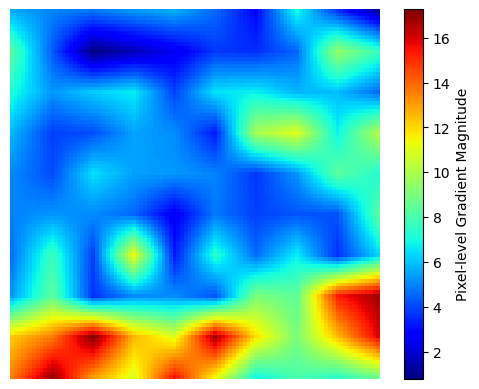

In [7]:
# Normalized
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom
import re
from transformers import AutoTokenizer

# image_path = "/cpfs04/user/hanyujin/rule-gen/datasets/mirrors/left/00001.png"
# image_path = "/cpfs04/user/hanyujin/rule-gen/datasets/mirrors/left/00003.png"
# image_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0/000003.png"
# image_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0/000009.png"
# image_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-JEPA-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0/000000.png"
image_path = "/cpfs04/user/hanyujin/rule-gen/experiments/samples/AE-JEPA-Diff-16-mirror-SiT-B-1-linear-vae0040000.pt-size-64cfg-4.0-seed-0/000005.png"
image_size = 128
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image_path,"resized_height":image_size,"resized_width":image_size},
            {"type": "text", "text": (
                "You are an expert in visual anomaly detection, focusing primarily on the shape and outline of objects. You will see images of an object in front of a mirror and its reflection. Specifically, please pay close attention to the outline and shape differences between the object in front of the mirror and its reflection, and consider whether they could reasonably be the front and back of the same object. If you think any inconsistency stems solely from color or texture design differences between the object and its reflection, please disregard it, since the front and back (or reflection) of an object may naturally vary in these aspects. Also keep in mind that perspective can cause some shape distortion in the reflection, but the overall outline should remain consistent."
                "Please rate each image individually on a scale from 0 (inconsistent) to 10 (completely harmonious and consistent). The specific scoring criteria are as follows:"
                "Score 10: Perfect match in shape and outline, considering the mirror flip."  
                "Score 9: Minor distortions due to perspective, but overall shape is recognizable."  
                "Score 8: Slight inconsistencies in shape, possibly due to object positioning or minor defects."  
                "Score 7: Moderate inconsistencies, where the general shape is similar but there are noticeable differences."  
                "Score 6: Significant inconsistencies, making it hard to recognize the reflection as the object’s reflection."  
                "Score 5: Equal parts consistent and inconsistent, borderline case."  
                "Score 4: Reflection shows a completely different shape, but some elements are similar."  
                "Score 3: Reflection bears little resemblance to the object."  
                "Score 2: Only a few parts of the reflection match the object."  
                "Score 1: Almost no similarity in shape and outline."  
                "Score 0: Reflection is completely different, no similarity at all."
                "Please think this step by step and answer in the the format: The score is {your_score}. The reason is {your_reason}."
                # "You are an expert in visual anomaly detection, focusing primarily on the shape and outline of objects. You will see an image of an object in front of a mirror and its reflection." 
                # "Specifically, please pay close attention to the outline and shape differences between the object in front of the mirror and its reflection, and consider whether they could reasonably be the front and back of the same object. If you think any inconsistency stems solely from color or texture design differences between the object and its reflection, please disregard it, since the front and back (or reflection) of an object may naturally vary in these aspects. Also keep in mind that perspective can cause some shape distortion in the reflection, but the overall outline should remain consistent."
                # "Please rate each image individually on a scale from 0 (inconsistent) to 10 (completely harmonious and consistent). "
                # "Please follow the format: The score is {your_score}. The reason is {your_reason}."
            )},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")


# ✅ 4. 启用梯度计算，重新 forward 计算 logits
inputs['pixel_values'].requires_grad = True  # 重新启用梯度
# 启用梯度计算，重新获取 logits 计算梯度
zero_logit = model(**inputs, output_hidden_states=False).logits[:, -1, :]
true_class = torch.argmax(zero_logit, dim=1)

# 计算 CrossEntropy Loss
criterion = nn.CrossEntropyLoss()
loss = -criterion(zero_logit, true_class)

# 计算 grads
grads = torch.autograd.grad(loss, inputs['pixel_values'], retain_graph=True)[0]
print(f"Grads shape: {grads.shape}")  # 应该是 [324, 1176] 或其他

# 重新 reshape grads
token_grid_size = int(np.sqrt(grads.shape[0]))  # 计算 token grid 的大小
grads = grads[:token_grid_size**2, :].view(token_grid_size, token_grid_size, -1)
print(f"Reshaped grads shape: {grads.shape}")  # [18, 18, 1176]

# 计算 grads 的范数
grad_norm = torch.norm(grads, dim=-1).detach().cpu().numpy()
print(f"Grad norm shape: {grad_norm.shape}")  # [18, 18]

## General
general_messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image_path,"resized_height":image_size,"resized_width":image_size},
            {"type": "text", "text": (
                "Write a general description of the image."
            )},
        ],
    }
]

# Preparation for inference
general_text = processor.apply_chat_template(
    general_messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
general_inputs = processor(
    text=[general_text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
general_inputs = general_inputs.to("cuda")

general_inputs['pixel_values'].requires_grad = True  # 重新启用梯度
# 启用梯度计算，重新获取 logits 计算梯度
general_zero_logit = model(**general_inputs, output_hidden_states=False).logits[:, -1, :]
general_true_class = torch.argmax(general_zero_logit, dim=1)

general_loss = -criterion(general_zero_logit, general_true_class)

# 计算 grads
general_grads = torch.autograd.grad(general_loss, general_inputs['pixel_values'], retain_graph=True)[0]
print(f"Grads shape: {general_grads.shape}")  # 应该是 [324, 1176] 或其他

# 重新 reshape grads
general_token_grid_size = int(np.sqrt(general_grads.shape[0]))  # 计算 token grid 的大小
general_grads = general_grads[:general_token_grid_size**2, :].view(general_token_grid_size, general_token_grid_size, -1)
print(f"General Reshaped grads shape: {general_grads.shape}")  # [18, 18, 1176]

# 计算 grads 的范数
general_grad_norm = torch.norm(general_grads, dim=-1).detach().cpu().numpy()
print(f"General Grad norm shape: {general_grad_norm.shape}")  # [18, 18]

grad_norm_norm = grad_norm/ general_grad_norm


# 获取动态图像尺寸
image_size = inputs['pixel_values'].shape[-2:]  # [height, width]
print(f"Image size: {image_size}")

# 计算 PATCH_SIZE 动态缩放（取最小值，确保是正方形）
PATCH_SIZE = min(image_size[0] // token_grid_size,
                 image_size[1] // token_grid_size)
print(f"PATCH_SIZE: {PATCH_SIZE}")

# 动态 zoom，将 token grid 映射回图像空间
grad_image = zoom(grad_norm_norm, (PATCH_SIZE, PATCH_SIZE), order=1)

# 可视化 grads 热力图
plt.imshow(grad_image, cmap='jet')
plt.colorbar(label="Pixel-level Gradient Magnitude")
plt.axis('off')
plt.show()

# print("The image_path is",image_path)
# print(f"Model Answer: {output_text}")
# pattern = r"The score is (\d+)"
# match = re.search(pattern,output_text[0])
# print(f"The score is: {int(match.group(1))}")


In [32]:
grads

tensor([[[-4.2915e-04, -9.8419e-04, -1.3046e-03,  ...,  3.9291e-04,
           4.4250e-04, -2.5749e-04],
         [ 2.2411e-04,  4.4250e-04,  1.8158e-03,  ...,  2.9945e-04,
          -1.6689e-04, -6.4373e-05],
         [ 1.1921e-05,  3.4142e-04,  2.8229e-04,  ..., -2.5177e-04,
           1.5354e-04, -2.1076e-04],
         ...,
         [ 8.6308e-05, -4.5395e-04, -9.9182e-04,  ...,  1.7471e-03,
           1.0071e-03,  7.0572e-04],
         [ 1.3351e-04,  2.3079e-04, -2.8992e-04,  ...,  4.6253e-05,
          -1.8597e-05,  1.3542e-04],
         [-4.7922e-05, -1.9646e-04, -1.6880e-04,  ..., -1.3828e-04,
          -3.5286e-04,  2.8992e-04]],

        [[-9.7656e-04, -2.1667e-03, -6.8665e-04,  ..., -4.3945e-03,
          -7.1716e-04, -1.5259e-04],
         [ 1.5259e-04, -2.3746e-04,  1.2970e-04,  ..., -1.5545e-04,
          -9.0122e-05, -4.1389e-04],
         [-2.2793e-04,  7.4387e-05,  8.8692e-05,  ...,  3.6812e-04,
           1.0490e-05, -1.4114e-04],
         ...,
         [-1.6689e-04, -2

In [31]:
general_grads

tensor([[[-4.2915e-04, -9.8419e-04, -1.3046e-03,  ...,  3.9291e-04,
           4.4250e-04, -2.5749e-04],
         [ 2.2411e-04,  4.4250e-04,  1.8158e-03,  ...,  2.9945e-04,
          -1.6689e-04, -6.4373e-05],
         [ 1.1921e-05,  3.4142e-04,  2.8229e-04,  ..., -2.5177e-04,
           1.5354e-04, -2.1076e-04],
         ...,
         [ 8.6308e-05, -4.5395e-04, -9.9182e-04,  ...,  1.7471e-03,
           1.0071e-03,  7.0572e-04],
         [ 1.3351e-04,  2.3079e-04, -2.8992e-04,  ...,  4.6253e-05,
          -1.8597e-05,  1.3542e-04],
         [-4.7922e-05, -1.9646e-04, -1.6880e-04,  ..., -1.3828e-04,
          -3.5286e-04,  2.8992e-04]],

        [[-9.7656e-04, -2.1667e-03, -6.8665e-04,  ..., -4.3945e-03,
          -7.1716e-04, -1.5259e-04],
         [ 1.5259e-04, -2.3746e-04,  1.2970e-04,  ..., -1.5545e-04,
          -9.0122e-05, -4.1389e-04],
         [-2.2793e-04,  7.4387e-05,  8.8692e-05,  ...,  3.6812e-04,
           1.0490e-05, -1.4114e-04],
         ...,
         [-1.6689e-04, -2

In [29]:
torch.autograd.grad(loss, inputs['pixel_values'], retain_graph=True)[0]

tensor([[-4.3869e-04, -9.9945e-04, -1.3351e-03,  ...,  3.8338e-04,
          4.6730e-04, -2.4796e-04],
        [ 2.1935e-04,  4.6730e-04,  1.8463e-03,  ...,  3.0136e-04,
         -1.8501e-04, -6.0797e-05],
        [ 7.1228e-06,  3.4523e-04,  2.8419e-04,  ..., -2.4128e-04,
          1.6499e-04, -2.0790e-04],
        ...,
        [-2.1648e-04,  2.3746e-04,  2.1648e-04,  ..., -1.1206e-04,
          4.5061e-05, -1.8406e-04],
        [-1.0872e-04,  4.6921e-04, -1.5926e-04,  ...,  5.1880e-04,
          3.6430e-04,  4.6492e-05],
        [-1.6117e-04, -2.5177e-04,  3.0398e-06,  ..., -4.7493e-04,
         -3.8147e-04,  1.5259e-04]], device='cuda:0')

In [28]:
torch.autograd.grad(general_loss, general_inputs['pixel_values'], retain_graph=True)[0]

tensor([[ 4.2282e-07,  4.2841e-07,  5.7369e-07,  ...,  3.6694e-07,
          5.0664e-07,  5.8860e-07],
        [-5.1036e-07, -7.4506e-07, -3.7253e-07,  ..., -2.7823e-08,
         -3.5577e-07, -5.2154e-07],
        [-2.4331e-08,  1.9930e-07, -5.9372e-08,  ..., -2.0023e-07,
         -4.1164e-07, -6.3330e-07],
        ...,
        [-1.1921e-07,  1.1036e-07,  2.4214e-07,  ...,  2.1141e-07,
          3.1479e-07,  1.6019e-07],
        [ 2.0023e-07, -1.5367e-07,  3.9814e-08,  ..., -1.6019e-07,
          2.0117e-07,  2.2724e-07],
        [-1.7928e-08, -2.7008e-07,  1.2945e-07,  ..., -4.5169e-08,
         -1.4028e-08, -3.4459e-07]], device='cuda:0')

In [27]:
grads 

tensor([[[-4.2915e-04, -9.8419e-04, -1.3046e-03,  ...,  3.9291e-04,
           4.4250e-04, -2.5749e-04],
         [ 2.2411e-04,  4.4250e-04,  1.8158e-03,  ...,  2.9945e-04,
          -1.6689e-04, -6.4373e-05],
         [ 1.1921e-05,  3.4142e-04,  2.8229e-04,  ..., -2.5177e-04,
           1.5354e-04, -2.1076e-04],
         ...,
         [ 8.6308e-05, -4.5395e-04, -9.9182e-04,  ...,  1.7471e-03,
           1.0071e-03,  7.0572e-04],
         [ 1.3351e-04,  2.3079e-04, -2.8992e-04,  ...,  4.6253e-05,
          -1.8597e-05,  1.3542e-04],
         [-4.7922e-05, -1.9646e-04, -1.6880e-04,  ..., -1.3828e-04,
          -3.5286e-04,  2.8992e-04]],

        [[-9.7656e-04, -2.1667e-03, -6.8665e-04,  ..., -4.3945e-03,
          -7.1716e-04, -1.5259e-04],
         [ 1.5259e-04, -2.3746e-04,  1.2970e-04,  ..., -1.5545e-04,
          -9.0122e-05, -4.1389e-04],
         [-2.2793e-04,  7.4387e-05,  8.8692e-05,  ...,  3.6812e-04,
           1.0490e-05, -1.4114e-04],
         ...,
         [-1.6689e-04, -2

In [26]:
general_grads 

tensor([[[-4.2915e-04, -9.8419e-04, -1.3046e-03,  ...,  3.9291e-04,
           4.4250e-04, -2.5749e-04],
         [ 2.2411e-04,  4.4250e-04,  1.8158e-03,  ...,  2.9945e-04,
          -1.6689e-04, -6.4373e-05],
         [ 1.1921e-05,  3.4142e-04,  2.8229e-04,  ..., -2.5177e-04,
           1.5354e-04, -2.1076e-04],
         ...,
         [ 8.6308e-05, -4.5395e-04, -9.9182e-04,  ...,  1.7471e-03,
           1.0071e-03,  7.0572e-04],
         [ 1.3351e-04,  2.3079e-04, -2.8992e-04,  ...,  4.6253e-05,
          -1.8597e-05,  1.3542e-04],
         [-4.7922e-05, -1.9646e-04, -1.6880e-04,  ..., -1.3828e-04,
          -3.5286e-04,  2.8992e-04]],

        [[-9.7656e-04, -2.1667e-03, -6.8665e-04,  ..., -4.3945e-03,
          -7.1716e-04, -1.5259e-04],
         [ 1.5259e-04, -2.3746e-04,  1.2970e-04,  ..., -1.5545e-04,
          -9.0122e-05, -4.1389e-04],
         [-2.2793e-04,  7.4387e-05,  8.8692e-05,  ...,  3.6812e-04,
           1.0490e-05, -1.4114e-04],
         ...,
         [-1.6689e-04, -2

In [25]:
loss

tensor(-0.1113, device='cuda:0', dtype=torch.bfloat16, grad_fn=<NegBackward0>)

In [24]:
general_loss

tensor(-3.5048e-05, device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<NegBackward0>)

In [23]:
true_class

tensor([71486], device='cuda:0')

In [22]:
general_true_class

tensor([4416], device='cuda:0')

In [21]:
zero_logit

tensor([[15.5625, 14.0625, 14.3750,  ..., -0.1016, -0.0991, -0.0986]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SliceBackward0>)

In [20]:
general_zero_logit

tensor([[ 8.1875,  7.0625,  4.9375,  ..., -0.9414, -0.9414, -0.9414]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SliceBackward0>)

In [19]:
inputs 

{'input_ids': tensor([[151644,   8948,    198,   2610,    525,    264,  10950,    323,  52897,
          17847,     13,   1446,    525,   1207,  16948,   7881,    553,  54364,
             13,   1446,   1265,   1744,   3019,  14319,  29208,     13, 151645,
            198, 151644,    872,    198, 151652, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151653,   2610,    525,    458,   6203,    304,
           9124,  62948,  17984,     11,  21080,  15503,    389,    279,   6083,
            323,  21101,    315,   6171,     13,   1446,    686,   1490,   5335,
            315,    458,   1633,    304,   4065,    315,    264,  17846,    323,
           1181,  21844,     13,  44763,     11,   4486,   2291,   3265,   6529,
            311,    279,  21101,    323,   6083,  11799,   1948,    279,   1633,
            30

In [18]:
general_inputs 

{'input_ids': tensor([[151644,   8948,    198,   2610,    525,    264,  10950,    323,  52897,
          17847,     13,   1446,    525,   1207,  16948,   7881,    553,  54364,
             13,   1446,   1265,   1744,   3019,  14319,  29208,     13, 151645,
            198, 151644,    872,    198, 151652, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151653,   7985,    264,   4586,   4008,    315,
            279,   2168,     13, 151645,    198, 151644,  77091,    198]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0'), 'pixel_values': tensor([[-0.3908, 

In [16]:
text

'<|im_start|>system\nYou are a helpful and harmless assistant. You are Qwen developed by Alibaba. You should think step-by-step.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>You are an expert in visual anomaly detection, focusing primarily on the shape and outline of objects. You will see images of an object in front of a mirror and its reflection. Specifically, please pay close attention to the outline and shape differences between the object in front of the mirror and its reflection, and consider whether they could reasonably be the front and back of the same object. If you think any inconsistency stems solely from color or texture design differences between the object and its reflection, please disregard it, since the front and back (or reflection) of an object may naturally vary in these aspects. Also keep in mind that perspective can cause some shape distortion in the reflection, but the overall outline should remain consistent.Please rate each image ind

In [17]:
general_text

'<|im_start|>system\nYou are a helpful and harmless assistant. You are Qwen developed by Alibaba. You should think step-by-step.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Write a general description of the image.<|im_end|>\n<|im_start|>assistant\n'

In [ ]:
grad_norm_norm = grad_norm/ general_grad_norm

In [15]:
grad_norm_norm

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)

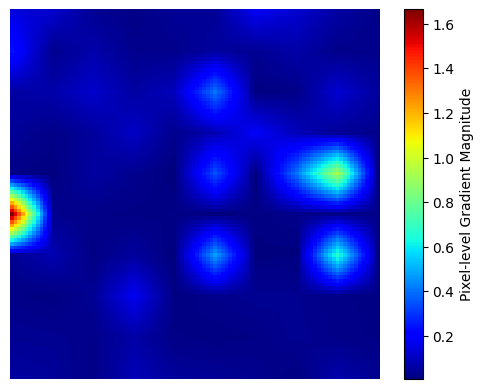

In [13]:
grad_image = zoom(general_grad_norm, (PATCH_SIZE, PATCH_SIZE), order=1)

# 可视化 grads 热力图
plt.imshow(grad_image, cmap='jet')
plt.colorbar(label="Pixel-level Gradient Magnitude")
plt.axis('off')
plt.show()

In [10]:
grad_norm

array([[0.14417318, 0.1233069 , 0.03901985, 0.01965109, 0.04291757,
        0.04268657, 0.1768915 , 0.12318547, 0.06167223, 0.02280029],
       [0.24090798, 0.03116317, 0.07288848, 0.030687  , 0.02859779,
        0.05397778, 0.03702023, 0.0682652 , 0.02545338, 0.02747158],
       [0.06053361, 0.07182215, 0.11874705, 0.06122192, 0.09665832,
        0.40246326, 0.01499622, 0.02235526, 0.1264971 , 0.05185298],
       [0.0481452 , 0.02297727, 0.05167146, 0.10997759, 0.03116283,
        0.08221456, 0.18790618, 0.09253251, 0.04279574, 0.02885521],
       [0.01957916, 0.01138858, 0.05900796, 0.0318412 , 0.00724146,
        0.34614965, 0.01150097, 0.41059187, 0.9284547 , 0.02053024],
       [1.6642601 , 0.03524266, 0.02218684, 0.0171306 , 0.02081957,
        0.01138176, 0.01597864, 0.02697565, 0.0238453 , 0.02323006],
       [0.03666985, 0.08189931, 0.01860373, 0.05288615, 0.00779334,
        0.4731602 , 0.01121018, 0.01190793, 0.66982466, 0.02540232],
       [0.02397092, 0.01336493, 0.0399687

Grads shape: torch.Size([1296, 1176])
Reshaped grads shape: torch.Size([36, 36, 1176])
Grad norm shape: (36, 36)
PATCH_SIZE_H: 36, PATCH_SIZE_W: 32


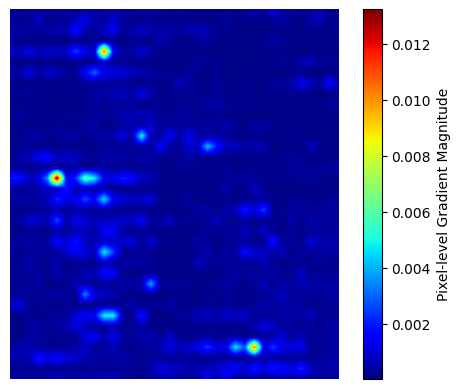

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# 计算 grads
grads = torch.autograd.grad(loss, inputs['pixel_values'], retain_graph=True)[0]
print(f"Grads shape: {grads.shape}")  # 应该是 [1296, 1176] 或其他

# 重新 reshape grads
token_grid_size = int(np.sqrt(grads.shape[0]))  # 计算 token grid 的大小
grads = grads[:token_grid_size**2, :].view(token_grid_size, token_grid_size, -1)
print(f"Reshaped grads shape: {grads.shape}")  # [grid_h, grid_w, embedding_size]

# 计算 grads 的范数
grad_norm = torch.norm(grads, dim=-1).detach().cpu().numpy()
print(f"Grad norm shape: {grad_norm.shape}")  # [grid_h, grid_w]

# 获取动态图像尺寸
image_size = inputs['pixel_values'].shape[-2:]  # [height, width]

# 计算 PATCH_SIZE 动态缩放
PATCH_SIZE_H = image_size[0] // token_grid_size
PATCH_SIZE_W = image_size[1] // token_grid_size
print(f"PATCH_SIZE_H: {PATCH_SIZE_H}, PATCH_SIZE_W: {PATCH_SIZE_W}")

# 动态 zoom，将 token grid 映射回图像空间
grad_image = zoom(grad_norm, (PATCH_SIZE_H, PATCH_SIZE_W), order=1)

# 可视化 grads 热力图
plt.imshow(grad_image, cmap='jet')
plt.colorbar(label="Pixel-level Gradient Magnitude")
plt.axis('off')
plt.show()


In [4]:
output_text 

["Alright, I've got this task to rate the consistency between an object and its reflection in a mirror. The object is a bench, and I need to look closely at its shape and outline to see how well it matches with its reflection. The rating scale goes from 0 to 10, with 10 being a perfect match and 0 being completely different.\n\nFirst, I need to understand what I'm supposed to focus on. The instruction says to pay attention to the shape and outline differences between the object and its reflection. It also mentions that color and texture differences should be ignored because the front and back of an object might have different designs. So, shape and outline are key here.\n\nI should also consider that perspective can cause some distortion in the reflection, but the overall outline should still be consistent. The score depends on how much inconsistency there is in the shape and outline.\n\nLet me look at the image. There's a wooden bench on a wooden floor in front of a mirror. The bench 

In [14]:
outputs

GenerateDecoderOnlyOutput(sequences=tensor([[151644,   8948,    198,  ...,   1124,     60, 151645]],
       device='cuda:0'), scores=(tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]], device='cuda:0'), tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]], device='cuda:0'), tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]], device='cuda:0'), tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]], device='cuda:0'), tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]], device='cuda:0'), tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]], device='cuda:0'), tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]], device='cuda:0'), tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]], device='cuda:0'), tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]], device='cuda:0'), tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]], device='cuda:0'), tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]], device='cuda:0'), tensor([[-inf, -inf, -inf,  ..., -inf, -inf, -inf]], device='cuda:0'), tensor([[-inf,

In [28]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt

# # 重新排列 grads 为 (9, 9, 1176) 的 token grid
# grads = grads[:81, :].view(9, 9, 1176)

# # 计算 token 的梯度范数
# grad_norm = torch.norm(grads, dim=-1).detach().cpu().numpy()

# # 可视化 token 级别的梯度热力图
# plt.imshow(grad_norm, cmap='jet')
# plt.colorbar(label="Token Gradient Magnitude")
# plt.title("Token-level Gradient Visualization")
# plt.axis('off')
# plt.show()


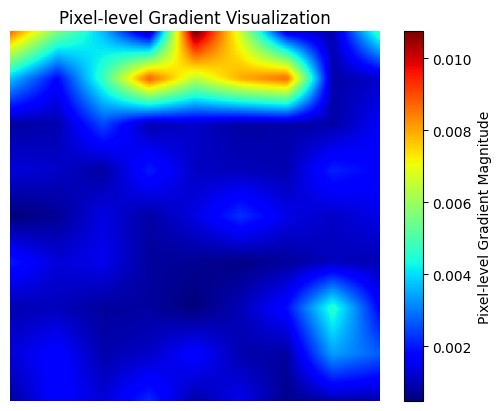

In [27]:
from scipy.ndimage import zoom
# 重新排列 grads 为 (9, 9, 1176) 的 token grid
grads = grads[:81, :].view(9, 9, 1176)

# 计算 token 的梯度范数
grad_norm = torch.norm(grads, dim=-1).detach().cpu().numpy()
# 将 token grid 映射回 128x128 图像空间
grad_image = zoom(grad_norm, (14, 14), order=1)

# 可视化映射后的梯度热力图
plt.imshow(grad_image, cmap='jet')
plt.colorbar(label="Pixel-level Gradient Magnitude")
plt.title("Pixel-level Gradient Visualization")
plt.axis('off')
plt.show()


In [ ]:
from skimage.measure import block_reduce
PATCH_SIZE = 14
grad = block_reduce(grads.cpu(), block_size=(PATCH_SIZE, PATCH_SIZE), func=np.mean)
print(grad.shape)